# Experimental Notebook

This notebook is intended as an experiment to look at building data in NYC.

In [1]:
import pandas as pd
import geopandas as gpd
import sodapy
from sodapy import Socrata
import matplotlib.pyplot as plt
import folium
import contextily as ctx
#the below are needed for the plotted heatmaps
import numpy as np
from scipy import ndimage
import matplotlib.pylab as pylab

API for NYC open data:

In [2]:
client = Socrata("data.cityofnewyork.us", '9llM0ejMVTKfRxS1XlvL7gXjU') 
#included my app token to reduce throttle limits

I found an interesting dataset that has all of the building footprints in NYC: https://data.cityofnewyork.us/Housing-Development/Building-Footprints/nqwf-w8eh.  Additional documentation can be found here: https://github.com/CityOfNewYork/nyc-geo-metadata/blob/master/Metadata/Metadata_BuildingFootprints.md.

In [3]:
buildingresults = client.get("cwab-e33n", content_type='geojson', where = 'groundelev < 11', limit = 71000)

I ran this with a limit of 200000 just to see how many buildings there are with a ground elevation of less than 11', which is the peak surge height from Hurricane Sandy. I got a return of 70,191 entries, so that is what I will plug in as the limit from here on. Lower than 11 feet of ground elevation is what I am defining as low elevation from here on, although it could also be thought of as vulnerable elevation.

In [4]:
low_elev_buildings = gpd.GeoDataFrame.from_features(buildingresults)

In [5]:
low_elev_buildings = low_elev_buildings.set_crs(4326)

This geopandas documentation, https://geopandas.readthedocs.io/en/latest/gallery/polygon_plotting_with_folium.html, said to use epsg 4326 for folium. 

In [6]:
low_elev_buildings.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
low_elev_buildings.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 70188 entries, 0 to 70187
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   geometry    70188 non-null  geometry
 1   name        176 non-null    object  
 2   base_bbl    70188 non-null  object  
 3   shape_area  70188 non-null  object  
 4   heightroof  69831 non-null  object  
 5   mpluto_bbl  69794 non-null  object  
 6   cnstrct_yr  68755 non-null  object  
 7   lststatype  70166 non-null  object  
 8   feat_code   70188 non-null  object  
 9   groundelev  70188 non-null  object  
 10  geomsource  70150 non-null  object  
 11  bin         70188 non-null  object  
 12  lstmoddate  70188 non-null  object  
 13  doitt_id    70188 non-null  object  
 14  shape_len   70188 non-null  object  
dtypes: geometry(1), object(14)
memory usage: 8.0+ MB


In [8]:
low_elev_buildings.head()

,geometry,name,base_bbl,shape_area,heightroof,mpluto_bbl,cnstrct_yr,lststatype,feat_code,groundelev,geomsource,bin,lstmoddate,doitt_id,shape_len
0,"MULTIPOLYGON (((-73.96113 40.57744, -73.96115 ...",None,3086910048,0,37.5,3086910048,1928,Constructed,2100,6,Photogramm,3245111,2017-08-22T00:00:00.000Z,786626,0
1,"MULTIPOLYGON (((-74.10309 40.57460, -74.10313 ...",None,5037020035,0,16.08,5037020035,1950,Constructed,2100,8,Photogramm,5053676,2017-08-22T00:00:00.000Z,105644,0
2,"MULTIPOLYGON (((-74.09960 40.56340, -74.09968 ...",None,5040820016,0,22.37,5040820016,1925,Constructed,2100,8,Photogramm,5056848,2017-08-22T00:00:00.000Z,753498,0
3,"MULTIPOLYGON (((-74.09305 40.58353, -74.09295 ...",None,5036520047,0,28.17,5036520047,1980,Constructed,2100,10,Photogramm,5052970,2017-08-22T00:00:00.000Z,598004,0
4,"MULTIPOLYGON (((-73.88582 40.63802, -73.88579 ...",None,3083060058,0,31.07057067,3083060058,1960,Constructed,2100,9,Photogramm,3234880,2017-08-22T00:00:00.000Z,205822,0


Changing the data types for certain columns to reflect that they are numbers.

In [9]:
low_elev_buildings.columns

Index(['geometry', 'name', 'base_bbl', 'shape_area', 'heightroof',
       'mpluto_bbl', 'cnstrct_yr', 'lststatype', 'feat_code', 'groundelev',
       'geomsource', 'bin', 'lstmoddate', 'doitt_id', 'shape_len'],
      dtype='object')

In [10]:
low_elev_buildings = low_elev_buildings.astype({"heightroof": float, "cnstrct_yr": float, "groundelev": float})

Creating a new dataset for the centroid of each building polygon.

In [11]:
building_points = low_elev_buildings.copy().to_crs(epsg=3857)

In [12]:
building_points.geometry = building_points['geometry'].centroid

<AxesSubplot:>

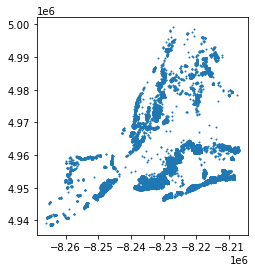

In [13]:
building_points.plot(markersize=1)

Now we have a dataset of points for all of the buildings in NYC with a ground elevation less than 11 feet.

Next I made individual datasets of each borough.

In [14]:
manhattanbuildings = building_points[building_points['base_bbl'].str.startswith('1')]
bronxbuildings = building_points[building_points['base_bbl'].str.startswith('2')]
brooklynbuildings = building_points[building_points['base_bbl'].str.startswith('3')]
queensbuildings = building_points[building_points['base_bbl'].str.startswith('4')]
statenislandbuildings = building_points[building_points['base_bbl'].str.startswith('5')]

In [15]:
manhattanbuildings.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2258 entries, 21 to 70158
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   geometry    2258 non-null   geometry
 1   name        38 non-null     object  
 2   base_bbl    2258 non-null   object  
 3   shape_area  2258 non-null   object  
 4   heightroof  2217 non-null   float64 
 5   mpluto_bbl  2245 non-null   object  
 6   cnstrct_yr  2098 non-null   float64 
 7   lststatype  2257 non-null   object  
 8   feat_code   2258 non-null   object  
 9   groundelev  2258 non-null   float64 
 10  geomsource  2257 non-null   object  
 11  bin         2258 non-null   object  
 12  lstmoddate  2258 non-null   object  
 13  doitt_id    2258 non-null   object  
 14  shape_len   2258 non-null   object  
dtypes: float64(3), geometry(1), object(11)
memory usage: 282.2+ KB


<AxesSubplot:>

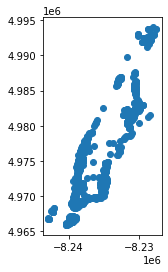

In [16]:
manhattanbuildings.plot()

I decided to try and make a heatmap plot to show where there are the highest concentrations of vulnerable buildings (low elevation) throughout NYC.  I found code online that would allow me to do so.

In [17]:
def heatmap(data, bins=(100,100), smoothing=1.3, cmap='jet'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(data.geometry.apply(getx))
    y = list(data.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.show()

/tmp/ipykernel_2193/904857451.py:13: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)


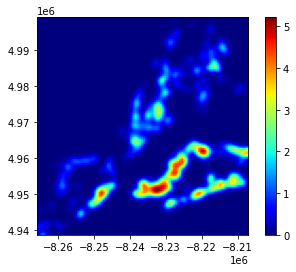

In [18]:
heatmap(building_points)

Above is a heatmap of the most vulnerable buildings throughout NYC.  Below, I ran a for loop to map vulnerabilities by borough.

In [19]:
boros = [manhattanbuildings, brooklynbuildings, queensbuildings, statenislandbuildings, bronxbuildings]

/tmp/ipykernel_2193/904857451.py:13: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)


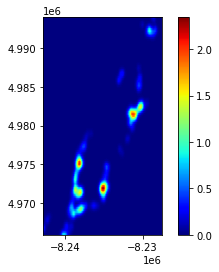

/tmp/ipykernel_2193/904857451.py:13: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)


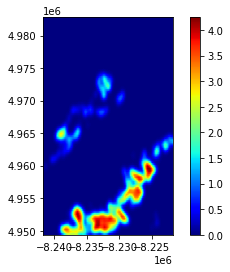

/tmp/ipykernel_2193/904857451.py:13: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)


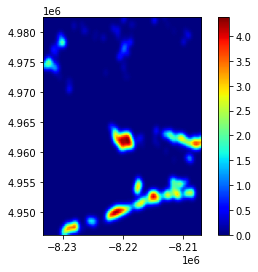

/tmp/ipykernel_2193/904857451.py:13: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)


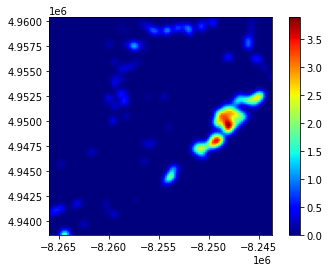

/tmp/ipykernel_2193/904857451.py:13: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)


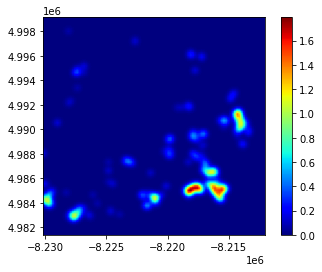

In [20]:
for boro in boros:
    heatmap(boro)

Unfortunately, without the basemaps for location context, the above heatmaps do not show very much.

Next, I tried to make an interactive heatmap with folium.

In [21]:
from folium import plugins
from folium.plugins import HeatMap

In [22]:
buildings_web = building_points.to_crs(epsg=4326)

In [23]:
m = folium.Map(location=[40.68, -74.0060], zoom_start=11, tiles='Stamen Terrain')

I needed to extract the latitude and longitude from the points in order to plot them on the heatmap.

In [24]:
buildings_web['lat'] = buildings_web['geometry'].y
buildings_web['lon'] = buildings_web['geometry'].x

In [25]:
buildings_web.head()

,geometry,name,base_bbl,shape_area,heightroof,mpluto_bbl,cnstrct_yr,lststatype,feat_code,groundelev,geomsource,bin,lstmoddate,doitt_id,shape_len,lat,lon
0,POINT (-73.96117 40.57742),None,3086910048,0,37.500000,3086910048,1928.0,Constructed,2100,6.0,Photogramm,3245111,2017-08-22T00:00:00.000Z,786626,0,40.577416,-73.961166
1,POINT (-74.10314 40.57462),None,5037020035,0,16.080000,5037020035,1950.0,Constructed,2100,8.0,Photogramm,5053676,2017-08-22T00:00:00.000Z,105644,0,40.574617,-74.103140
2,POINT (-74.09966 40.56337),None,5040820016,0,22.370000,5040820016,1925.0,Constructed,2100,8.0,Photogramm,5056848,2017-08-22T00:00:00.000Z,753498,0,40.563368,-74.099659
3,POINT (-74.09298 40.58357),None,5036520047,0,28.170000,5036520047,1980.0,Constructed,2100,10.0,Photogramm,5052970,2017-08-22T00:00:00.000Z,598004,0,40.583573,-74.092977
4,POINT (-73.88575 40.63804),None,3083060058,0,31.070571,3083060058,1960.0,Constructed,2100,9.0,Photogramm,3234880,2017-08-22T00:00:00.000Z,205822,0,40.638038,-73.885751


Next I created a gdf of just the latitude and longitude data for each point, combined into a single column.

In [26]:
buildings_heat = [[row['lat'],row['lon']] for index, row in buildings_web.iterrows()]

Then, using the HeatMap function from folium, I added the points to the map.

In [27]:
HeatMap(buildings_heat, name='Vulnerable Buildings', radius=5, blur=5).add_to(m)

In [28]:
m

As you can see in the interactive heatmap above, the highest concentrations of vulnerable/low elevation buildings are in Brooklyn, Queens, and Staten Island.  This can inform our analysis going forward by allowing us to hone in on those locations that are most at risk to flooding.

Furthermore, the building point data can be used in spatial joins to perform spatial autocorrelation analysis as to where certain locations are most vulnerable (perhaps looking at race as compared to number of vulnerable buildings).